Run these, then use these results to test multiple hidden models and look at weights for both of these networks.
Then run annealed for multiple epochs, using result from fixed dropout, also run the newBob learning.

L1 Experiments

In [13]:
# %load Experiments/l1Experiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = [0.005,0.001,0.0005,0.0001,0.00005]
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("l1RegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(l1_weight):
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        ''' elif layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        elif layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            '''
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight[index], 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['l1F'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 318.031. Accuracy is 9.28%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 318.014. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 300.927. Accuracy is 85.75%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 300.428. Accuracy is 92.54%
INFO:mlp.optimisers:Epoch 1: Took 79 seconds. Training speed 697 pps. Validation speed 1418 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 283.063. Accuracy is 91.84%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 283.024. Accuracy is 92.97%
INFO:mlp.optimisers:Epoch 2: Took 79 seconds. Training speed 692 pps. Validation speed 1429 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 266.249. Accuracy is 93.19%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 266.218. Accuracy is 94.41%
INFO:mlp.optimisers:Epoch 3: Took 79 seco

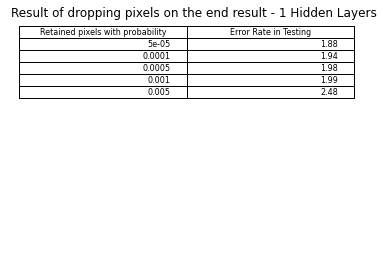

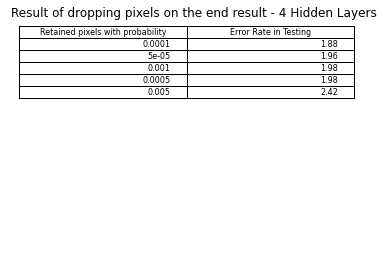

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [26]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("l1RegExperiments")
tracker = []

l1_weight = [0.005,0.001,0.0005,0.0001,0.00005]
for val in xrange(0,5):
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L1 Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of L1 on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(0,5):
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L1 Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of L1 on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''






L2 Experiments

In [14]:
# %load Experiments/l2Experiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = [0.0005,0.0001,0.00005,0.00001,0.000005]
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("l2RegExperiments", writeback = True)

stats = []
rate = 2
for index,item in enumerate(l2_weight):
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight[index])

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['l2F'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 4.665. Accuracy is 9.28%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 4.648. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.914. Accuracy is 85.84%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.415. Accuracy is 92.61%
INFO:mlp.optimisers:Epoch 1: Took 72 seconds. Training speed 764 pps. Validation speed 1523 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.442. Accuracy is 92.07%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.400. Accuracy is 93.40%
INFO:mlp.optimisers:Epoch 2: Took 72 seconds. Training speed 769 pps. Validation speed 1496 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.414. Accuracy is 93.56%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.385. Accuracy is 94.70%
INFO:mlp.optimisers:Epoch 3: Took 71 seconds. Training sp

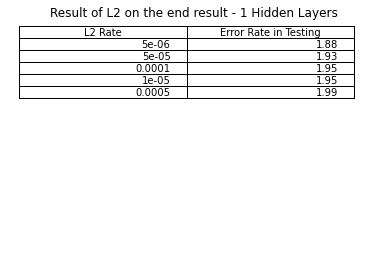

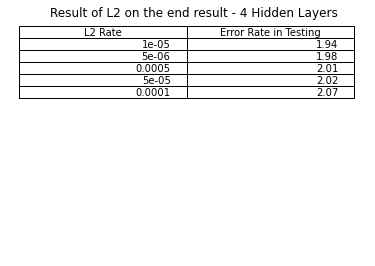

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [28]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("l2RegExperiments")
tracker = []

l2_weight = [0.0005,0.0001,0.00005,0.00001,0.000005]
for val in xrange(0,5):
    tracker.append([l2_weight[val], 100-(100*shelve_p[('l2F0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L2 Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of L2 on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(0,5):
    tracker.append([l2_weight[val], 100-(100*shelve_p[('l2F1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L2 Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of L2 on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''







Dropout fixed Experiments

In [15]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutFixed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.000
dropout = [0.6,0.55,0.5,0.45,0.4]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropRegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutFixed(dropout[index], dropout[index])
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropNF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.570. Accuracy is 9.28%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.877. Accuracy is 77.50%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.300. Accuracy is 91.56%
INFO:mlp.optimisers:Epoch 1: Took 68 seconds. Training speed 802 pps. Validation speed 1857 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.462. Accuracy is 85.64%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.268. Accuracy is 92.17%
INFO:mlp.optimisers:Epoch 2: Took 66 seconds. Training speed 825 pps. Validation speed 1853 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.405. Accuracy is 87.63%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.230. Accuracy is 93.78%
INFO:mlp.optimisers:Epoch 3: Took 68 seconds. Training sp

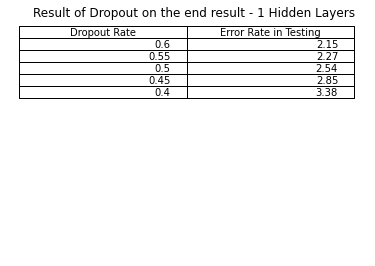

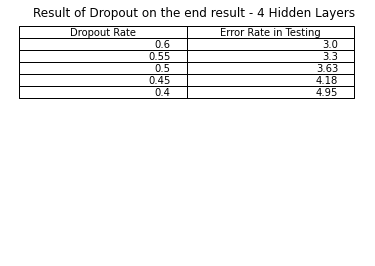

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [29]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("dropRegExperiments")
tracker = []


dropout = [0.6,0.55,0.5,0.45,0.4]
for val in xrange(0,5):
    tracker.append([dropout[val], 100-(100*shelve_p[('dropNF0'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Dropout Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of Dropout on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

tracker = []
for val in xrange(0,5):
    tracker.append([dropout[val], 100-(100*shelve_p[('dropNF1'+str(val))][2][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Dropout Rate', 'Error Rate in Testing')
plt.axis('off')
plt.title('Result of Dropout on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
plt.table(cellText=tracker,colLabels=columns, loc='best')

plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''








In [ ]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=1000, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.000
dropout = [0.01,0.005,0.001,0.0005,0.0001]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropAnnRegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutAnnealed(0.6, 0.6, dropout[val])
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropAF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.570. Accuracy is 9.28%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.872. Accuracy is 77.41%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.300. Accuracy is 91.59%
INFO:mlp.optimisers:Epoch 1: Took 70 seconds. Training speed 786 pps. Validation speed 1675 pps.
